# **NOAA Workshop - Rainfall Skill Explorer**
**Training Guide for KMD, UNMA, and Meteo Rwanda**

**Workshop Title:** Rainfall Product Skill Assessment & Flood Case Studies
**Duration:** ~2 hours (hands-on session)
**Notebook:** `NOAA_Rainfall_Skill_Explorer_v2.ipynb`

#### **1. Objectives**

By completing this exercise, you will:
* Learn how to use the Rainfall Skill Explorer Jupyter Notebook to evaluate multiple rainfall products.
* Assess the skill, bias, and reliability of CHIRPS, TAMSAT, IMERG, and ERA5 against validated ground stations.
* Explore long-term rainfall trends (2014-2024) in your country's capital.
* Analyze how each dataset captured severe flood events in Kenya, Uganda, and Rwanda.
* Discuss operational implications for early warning, forecasting, and product selection.

#### **2. Dataset Overview**

| Category | Dataset | Source | Spatial Resolution | Temporal Coverage | Notes |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Ground Observations** | TAHMO / National Met Stations | Met agencies | Point | Daily | High-confidence QC from Notebook 1 |
| **Satellite Products** | CHIRPS | UCSB/ FEWS NET | $0.05^{\circ}$ (~5 km) | 1981-present | May underestimate convective extremes |
| | TAMSAT | University of Reading | 0.0375° (~4 km) | 1983-present | Strong climatology, may miss isolated storms |
| | IMERG (GPM) | NASA | 0.1° (~10 km) | 2000-present | Good detection of extremes, higher variance |
| **Reanalysis** | ERA5 | ECMWF | 0.25° (~25 km) | 1979-present | Smooth but underestimates short bursts |

#### **3. Notebook Key steps**
- Step 1: Load datasets (Ground and Satellite)
- Step 2: Load helper functions
- Step 3: Prepare ground data
- Step 4: Define the parameters for analysis
- Step 5: Long term precipitation trends and climatology
- Step 6: Ground vs Satellite products
- Step 7) Calculate spatial bias (optional)
- Step 8) Run case study


#### **4. Case Study Contexts**

##### 4.1 Kenya – Mai Mahiu Flash Flood (Nakuru County)
* **Date:** 29 April 2024 * **Window:** 20 April - 5 May 2024

##### 4.2 Uganda - Mbale-Kapchorwa Floods (Eastern Region)
* **Date:** 30 July 2022 * **Window:** 28 July - 2 August 2022

##### 4.3 Rwanda – Western & Northern Provinces Floods
* **Date:** 2 May 2023 * **Window:** 1 May - 8 May 2023


#### **5. Outputs**
Each team should produce PNG figures and CSV outputs, which will be saved in the `Results_SkillExplorer_<country>_<date>` folder.

#### **6. Interpretation Template (for group reporting)**

| Country | Station / Event | Best Performing Product | Main Finding | Operational Implication |
| :--- | :--- | :--- | :--- | :--- |
| **Kenya** | KE-012 Mai Mahiu (2024) | IMERG | Best extreme detection; CHIRPS underestimates | Combine IMERG for flood alerting + ERA5 for background context |
| **Uganda** | UG-00456 Mbale-Kapchorwa (2022) | ERA5 | Consistent timing; TAMSAT misses short bursts | ERA5 captures system-scale but misses extremes |
| **Rwanda** | RW-00789 Western Floods (2023) | TAMSAT | Good match to ground totals; ERA5 underestimates | Regional bias correction could improve early warnings |


**Audience:** KMD, UNMA, Meteo Rwanda  

In [41]:
# @title Step 1: Load datasets (Ground and Satellite) {"display-mode":"both"}

# 💡 This step loads previously downloaded datasets: TAHMO(Ground), CHIRPS, IMERG, TAMSAT, ERA5

# 💡 Use this cell to change file names at section GROUND_CSV if needed

# 1) CONFIG
import os, numpy as np, pandas as pd
from datetime import date
from google.colab import drive
drive.mount('/content/drive')


# Set the environment path to the shared drive folder
shared_drive_path = '/content/drive/Shared drives/NOAA-workshop2/Datasets' # Path to datafiles

CAPITALS={'Kenya':{'name':'Nairobi','lat':-1.2921,'lon':36.8219},'Uganda':{'name':'Kampala','lat':0.3476,'lon':32.5825},'Rwanda':{'name':'Kigali','lat':-1.9579,'lon':30.1127}}
COUNTRY = 'Rwanda'
os.chdir(os.path.join(shared_drive_path, COUNTRY)) # set working directory to country sub folder
print(f"Working directory set to: {os.getcwd()}")

GROUND_CSV=f'./tahmo_precip_2014-01-01_2024-12-31_{COUNTRY}.csv'; CHIRPS_NC=f'./CHIRPS_2014-01-01_2024-12-31_{COUNTRY}.nc'; TAMSAT_NC=f'./TAMSAT_precip_2014-01-01_2024-12-31_{COUNTRY}.nc'; IMERG_NC=f'./IMERG_daily.nc'; ERA5_NC=f'./ERA5_precip_2014-01-01_2024-12-31_{COUNTRY}.nc'
START_DATE='2014-01-01'; END_DATE='2024-12-31'; LTN_BASE=('2014-01-01','2024-12-31')
NEIGHBORHOOD=1; EXTREME_THRESHOLDS=[20,50,100]; CORR_METHOD='pearson'
EVENTS={'Kenya – Mai Mahiu flash flood (2024-04-29)':('2024-04-20','2024-05-05'),'Uganda – Mbale–Kapchorwa floods (2022-07-30)':('2022-07-28','2022-08-02'),'Rwanda – Western/Northern floods (2023-05-02)':('2023-05-01','2023-05-08')}
RUN_STAMP=date.today().isoformat(); RESULTS_DIR=f'/content/drive/MyDrive/Results_SkillExplorer_{COUNTRY}_{RUN_STAMP}'; os.makedirs(RESULTS_DIR, exist_ok=True); np.random.seed(42)
print('✅ CONFIG set →', RESULTS_DIR)

# Check if data files exist
data_files = [GROUND_CSV, CHIRPS_NC, TAMSAT_NC, IMERG_NC, ERA5_NC]

print("Checking for data files:")
for data_file_var in data_files:
    if os.path.exists(data_file_var):
        print(f"✅ {data_file_var} found.")
    else:
        print(f"❌ {data_file_var} not found.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory set to: /content/drive/Shared drives/NOAA-workshop2/Datasets/Rwanda
✅ CONFIG set → /content/drive/MyDrive/Results_SkillExplorer_Rwanda_2025-10-15
Checking for data files:
✅ ./tahmo_precip_2014-01-01_2024-12-31_Rwanda.csv found.
✅ ./CHIRPS_2014-01-01_2024-12-31_Rwanda.nc found.
✅ ./TAMSAT_precip_2014-01-01_2024-12-31_Rwanda.nc found.
❌ ./IMERG_daily.nc not found.
✅ ./ERA5_precip_2014-01-01_2024-12-31_Rwanda.nc found.


In [76]:
# @title Step 2: Load helper functions {"display-mode":"form"}

# @markdown This cell defines several helper functions that are used later in the notebook for data processing and analysis.

# @markdown These include code extract timeseries, calculate sums etc.

# 2) HELPERS
import numpy as np, pandas as pd, os
def load_ground(p):
    if not os.path.exists(p): print('⚠️ Ground CSV not found:', p); return None
    df=pd.read_csv(p,parse_dates=['date']); req={'station_id','date','precip','lat','lon'}; miss=req-set(df.columns)
    if miss: print('⚠️ Missing cols:',miss); return None
    if 'high_confidence' in df.columns: df=df[df['high_confidence']==True].copy()
    return df
def open_nc(p):
    try:
        import xarray as xr
        return xr.open_dataset(p) if os.path.exists(p) else None
    except Exception as e: print('ℹ️ xarray error:', e); return None
def _near(arr,val):
    arr=np.asarray(arr); return int(np.argmin(np.abs(arr-val)))
def extract_timeseries(ds,lat,lon,k=1):
    if ds is None: return None
    import pandas as pd
    var=list(ds.data_vars)[0] if ds.data_vars else None
    if var is None: return None

    # Check for 'lat'/'lon' or 'y'/'x' dimensions
    if 'lat' in ds.coords and 'lon' in ds.coords:
        lats = ds['lat'].values
        lons = ds['lon'].values
        lat_dim, lon_dim = 'lat', 'lon'
    elif 'y' in ds.coords and 'x' in ds.coords:
        lats = ds['y'].values
        lons = ds['x'].values
        lat_dim, lon_dim = 'y', 'x'
    else:
        print(f"⚠️ Could not find 'lat'/'lon' or 'y'/'x' dimensions in dataset.")
        return None

    da=ds[var]
    lon_w=lon if not(lons.min()>=0 and lons.max()>180 and lon<0) else lon%360.0
    i=_near(lats,lat); j=_near(lons,lon_w)

    if k==1:
        sub=da.isel({lat_dim:i, lon_dim:j})
    else:
        sub=da.isel({lat_dim:slice(max(i-k//2,0),i+k//2+1), lon_dim:slice(max(j-k//2,0),j+k//2+1)}).mean(dim=[lat_dim,lon_dim],skipna=True)

    try: ts=sub.to_series()
    except Exception: ts=pd.Series(sub.values,index=pd.to_datetime(ds['time'].values))
    if ts.dropna().quantile(0.99)<1.0: ts=ts*1000.0
    return ts
def monthly_sum(ts):
    return None if ts is None or ts.empty else ts.resample('MS').sum(min_count=1)
def mann_kendall(ms):
    s=ms.dropna().values; n=len(s)
    if n<8: return {'slope':np.nan,'p':np.nan,'direction':'insufficient'}
    S=0
    for i in range(n-1): S+=np.sum(np.sign(s[i+1:]-s[i]))
    varS=(n*(n-1)*(2*n+5))/18.0
    z=(S-1)/np.sqrt(varS) if S>0 else ((S+1)/np.sqrt(varS) if S<0 else 0.0)
    from math import erf, sqrt; Phi=lambda z:0.5*(1.0+erf(z/np.sqrt(2.0))); p=2*(1-Phi(abs(z)))
    x=np.arange(n); slopes=[]
    for i in range(n-1): dx=(x[i+1:]-x[i]); dy=(s[i+1:]-s[i]); slopes+=list(dy/dx)
    slope=float(np.median(slopes)); direction='increasing' if slope>0 and p<0.05 else ('decreasing' if slope<0 and p<0.05 else 'no_significant_trend')
    return {'slope':slope,'p':float(p),'direction':direction}
def metrics(gt,mod,ths):
    df=pd.concat([gt.rename('gt'),mod.rename('mod')],axis=1).dropna()
    if df.empty: return None
    rmse=float(np.sqrt(((df['mod']-df['gt'])**2).mean())); bias=float((df['mod']-df['gt']).abs().mean())
    cp=df.corr(method='pearson').iloc[0,1]; cs=df.corr(method='spearman').iloc[0,1]
    hits={}
    for th in ths:
        gt_hit=df['gt']>=th; mod_hit=df['mod']>=th; denom=int(gt_hit.sum()); hits[f'hitrate_{th}mm']=float((gt_hit&mod_hit).sum()/denom) if denom>0 else np.nan
    return {'rmse':rmse,'bias':bias,'corr_pearson':float(cp),'corr_spearman':float(cs),**hits}

print("✅ Helper functions loaded successfully")

✅ Helper functions loaded successfully


In [43]:
# @title Step 3: Prepare ground data {"display-mode":"form"}

# @markdown This step Loads and prepares ground truth data from time series and metadata CSV files.
# 3) LOAD
import pandas as pd

def load_ground_from_files(time_series_path, metadata_path):
    """
    Loads and prepares ground truth data from time series and metadata CSV files.

    Args:
        time_series_path (str): Path to the time series CSV file.
        metadata_path (str): Path to the metadata CSV file.

    Returns:
        pandas.DataFrame: Processed ground truth data or None if files are not found or data is empty.
    """
    if not os.path.exists(time_series_path):
        print('⚠️ Ground time series CSV not found:', time_series_path)
        return None
    if not os.path.exists(metadata_path):
        print('⚠️ Ground metadata CSV not found:', metadata_path)
        return None

    df_ts = pd.read_csv(time_series_path, parse_dates=['date'])
    df_meta = pd.read_csv(metadata_path)

    if df_ts.empty or df_meta.empty:
        print('⚠️ Ground truth or metadata is empty.')
        return None

    # Reshape time series data
    df_melted = df_ts.melt(id_vars=['date'], var_name='station_id', value_name='precip').dropna(subset=['precip'])

    # Merge with metadata
    # Assuming the metadata station id column is named 'code' and location columns 'location.latitude', 'location.longitude'
    df_merged = pd.merge(df_melted, df_meta[['code', 'location.latitude', 'location.longitude']],
                         left_on='station_id', right_on='code', how='left')

    # Rename columns to match the expected format
    df_merged = df_merged.rename(columns={'location.latitude': 'lat', 'location.longitude': 'lon'})

    # Check for required columns after merging
    req = {'station_id', 'date', 'precip', 'lat', 'lon'}
    miss = req - set(df_merged.columns)
    if miss:
        print('⚠️ Missing required columns after merge:', miss)
        return None

    # Drop the redundant 'code' column
    df_merged = df_merged.drop(columns=['code'])

    # Convert START_DATE and END_DATE to timezone-aware datetime objects in UTC
    start_date_utc = pd.to_datetime(START_DATE, utc=True)
    end_date_utc = pd.to_datetime(END_DATE, utc=True)

    # Filter by date range using timezone-aware comparison
    df_processed = df_merged[(df_merged['date'] >= start_date_utc) & (df_merged['date'] <= end_date_utc)].copy()

    if 'high_confidence' in df_processed.columns:
        df_processed = df_processed[df_processed['high_confidence'] == True].copy()

    return df_processed

# Load ground truth data using the new function
metadata_csv = './tahmo_metadata.csv' # Assuming this is the path to the metadata file
df_gt = load_ground_from_files(GROUND_CSV, metadata_csv)


ds_chirps=open_nc(CHIRPS_NC); ds_tamsat=open_nc(TAMSAT_NC); ds_imerg=open_nc(IMERG_NC); ds_era5=open_nc(ERA5_NC)

if df_gt is not None:
    print('✅ Ground rows:',len(df_gt))
else:
    print('❌ Ground data could not be loaded.')

✅ Ground rows: 30141


In [44]:
# @title Step 4: Define the parameters for analysis {"display-mode":"form"}

# @markdown This cell creates widgets to allow you to easily control the parameters for the analysis in the subsequent cells without directly modifying the code.
# 4) WIDGETS
import ipywidgets as W
from IPython.display import display
country_w=W.Dropdown(options=['Kenya','Uganda','Rwanda'],value=COUNTRY,description='Country:')
stations=sorted(df_gt['station_id'].unique().tolist()) if df_gt is not None and not df_gt.empty else []
station_w=W.Dropdown(options=stations,description='Station:')
dataset_w=W.SelectMultiple(options=['CHIRPS','TAMSAT','IMERG','ERA5'],value=('CHIRPS','TAMSAT','IMERG','ERA5'),description='Datasets:')
thresh_w=W.SelectMultiple(options=[20,50,100],value=(20,50,100),description='≥ Thresholds:')
event_w=W.Dropdown(options=list(EVENTS.keys()),value=list(EVENTS.keys())[0],description='Case study:')
display(country_w,station_w,dataset_w,thresh_w,event_w); print('✅ Controls ready')

Dropdown(description='Country:', index=2, options=('Kenya', 'Uganda', 'Rwanda'), value='Rwanda')

Dropdown(description='Station:', options=('TA00075_S000795', 'TA00075_S000798', 'TA00075_S001588', 'TA00180', …

SelectMultiple(description='Datasets:', index=(0, 1, 2, 3), options=('CHIRPS', 'TAMSAT', 'IMERG', 'ERA5'), val…

SelectMultiple(description='≥ Thresholds:', index=(0, 1, 2), options=(20, 50, 100), value=(20, 50, 100))

Dropdown(description='Case study:', options=('Kenya – Mai Mahiu flash flood (2024-04-29)', 'Uganda – Mbale–Kap…

✅ Controls ready


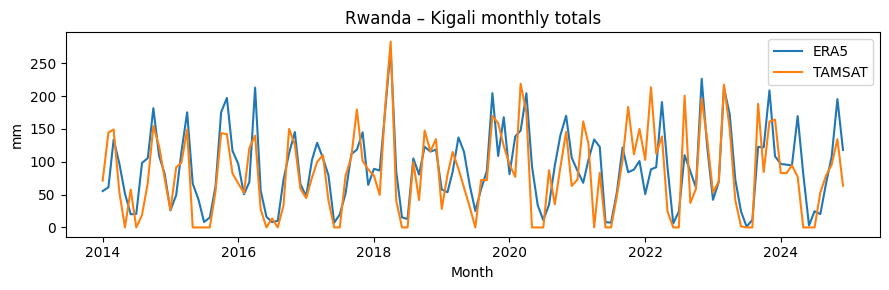

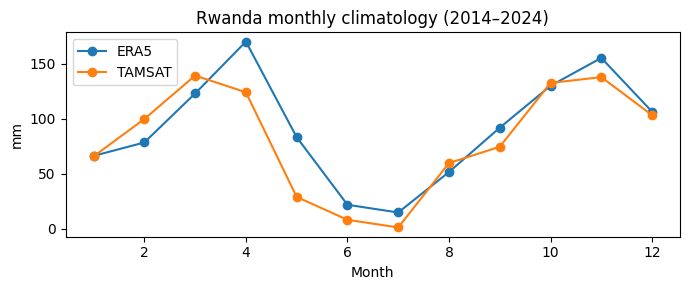

,dataset,slope,p,direction
0,ERA5,0.107048,0.366567,no_significant_trend
1,TAMSAT,0.046482,0.355195,no_significant_trend


- ERA5: slope=0.11 mm/mon, p=0.367, trend=no_significant_trend
- TAMSAT: slope=0.05 mm/mon, p=0.355, trend=no_significant_trend
✅ LTN exports saved


In [80]:
# @title Step 5: Long term precipitation trends and climatology {"display-mode":"form"}

# @markdown This section focuses on analyzing long-term monthly precipitation trends and climatology for the capital city of the country
# 5) LTN & TRENDS
import matplotlib.pyplot as plt, pandas as pd, os
cap=CAPITALS[country_w.value]
series={}
for name,ds in [('ERA5',ds_era5),('TAMSAT',ds_tamsat),('IMERG',ds_imerg)]:
    ts=extract_timeseries(ds,cap['lat'],cap['lon'],k=NEIGHBORHOOD)
    if ts is None: continue
    ts=ts[(ts.index>=pd.to_datetime(LTN_BASE[0]))&(ts.index<=pd.to_datetime(LTN_BASE[1]))]
    ms=monthly_sum(ts);
    if ms is not None: series[name]=ms
if series:
    fig=plt.figure(figsize=(9,3))
    for n,ms in series.items(): plt.plot(ms.index,ms.values,label=n)
    plt.title(f"{country_w.value} – {cap['name']} monthly totals"); plt.ylabel('mm'); plt.xlabel('Month'); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,f"ltn_monthly_{country_w.value}.png")); plt.show()
    clims={n:ms.groupby(ms.index.month).mean() for n,ms in series.items()}
    fig=plt.figure(figsize=(7,3))
    for n,cl in clims.items(): plt.plot(range(1,13),cl.values,marker='o',label=n)
    plt.title(f"{country_w.value} monthly climatology (2014–2024)"); plt.xlabel('Month'); plt.ylabel('mm'); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,f"ltn_climatology_{country_w.value}.png")); plt.show()
    rows=[{'dataset':n,**mann_kendall(ms)} for n,ms in series.items()]; df_trends=pd.DataFrame(rows); display(df_trends)
    df_trends.to_csv(os.path.join(RESULTS_DIR,f"ltn_trends_{country_w.value}.csv"),index=False)
    for _,r in df_trends.iterrows(): print(f"- {r['dataset']}: slope={r['slope']:.2f} mm/mon, p={r['p']:.3f}, trend={r['direction']}")
    print('✅ LTN exports saved')
else:
    print('ℹ️ No LTN series available (check NetCDFs).')

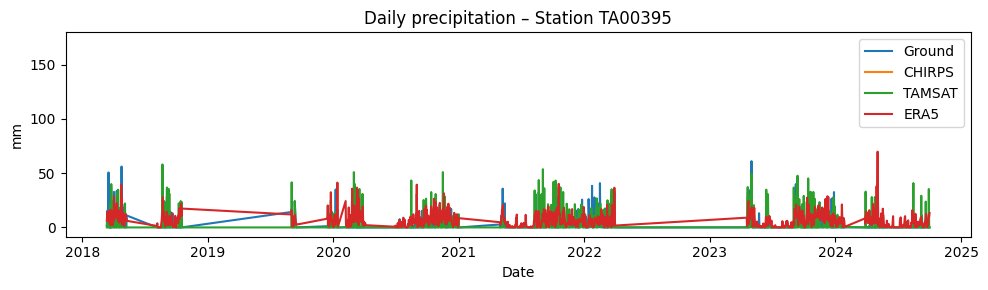

,dataset,rmse,bias,corr_pearson,corr_spearman,hitrate_50mm
0,ERA5,8.556304,5.604134,0.296872,0.531724,0.0
1,TAMSAT,9.073649,4.171734,0.311933,0.340405,0.0
2,CHIRPS,23.077981,15.150217,0.345711,0.492174,NaN


✅ Station metrics saved


In [77]:
# @title Step 6: Ground vs Satellite products {"display-mode":"form"}

# @markdown This section assesses the skill of the different rainfall datasets against ground truth observations at a specific station
# 6) STATION SKILL
import matplotlib.pyplot as plt, os, pandas as pd, numpy as np
if df_gt is None or df_gt.empty or station_w.value is None: print('⚠️ Select station / load ground.')
else:
    sid=station_w.value; st=df_gt[df_gt['station_id']==sid].sort_values('date'); lat,lon=float(st['lat'].iloc[0]),float(st['lon'].iloc[0])
    series={'GROUND': st.set_index('date')['precip']}
    src={'CHIRPS':ds_chirps,'TAMSAT':ds_tamsat,'IMERG':ds_imerg,'ERA5':ds_era5}
    for d in dataset_w.value:
        ts=extract_timeseries(src.get(d),lat,lon,k=NEIGHBORHOOD)
        if ts is not None:
            try:
                # Make the extracted timeseries timezone aware (UTC) to match the ground truth data
                series[d]=ts.tz_localize('UTC')
            except TypeError:
                # If already timezone aware, assume UTC
                series[d]=ts.tz_convert('UTC')

    fig=plt.figure(figsize=(10,3)); plt.plot(series['GROUND'].index,series['GROUND'].values,label='Ground')
    for d in dataset_w.value:
        if d in series:
            aligned=series[d].reindex(series['GROUND'].index); plt.plot(aligned.index,aligned.values,label=d)
    plt.title(f"Daily precipitation – Station {sid}"); plt.xlabel('Date'); plt.ylabel('mm'); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,f"station_ts_{sid}.png")); plt.show()
    rows=[]
    for d in dataset_w.value:
        if d not in series: continue
        met=metrics(series['GROUND'],series[d],thresh_w.value)
        if met: rows.append({'dataset':d,**met})
    if rows:
        dfm=pd.DataFrame(rows).sort_values(['rmse','bias','corr_pearson'],ascending=[True,True,False]).reset_index(drop=True)
        display(dfm); dfm.to_csv(os.path.join(RESULTS_DIR,f"metrics_station_{sid}.csv"),index=False); print('✅ Station metrics saved')

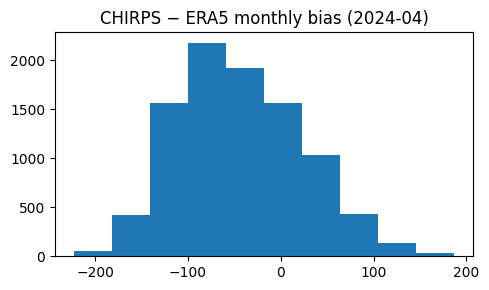

✅ bias_CHIRPS_2024-04.png


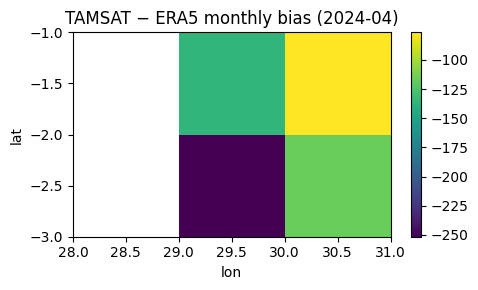

✅ bias_TAMSAT_2024-04.png


In [78]:
# @title Step 7) Calculate spatial bias (optional)  {"display-mode":"form"}
# 7) SPATIAL BIAS (optional)

# @markdown This section calculates and visualizes the spatial bias of the CHIRPS, TAMSAT, and IMERG datasets relative to ERA5 for a specific target month
import matplotlib.pyplot as plt, os
TARGET_MONTH='2024-04'
if ds_era5 is None: print('ℹ️ ERA5 missing; skip spatial bias.')
else:
    import xarray as xr
    era5=ds_era5[list(ds_era5.data_vars)[0]]; era5_m=era5.sel(time=slice(f"{TARGET_MONTH}-01",f"{TARGET_MONTH}-28")).sum(dim='time',skipna=True)
    for name,ds in [('CHIRPS',ds_chirps),('TAMSAT',ds_tamsat),('IMERG',ds_imerg)]:
        if ds is None: continue
        var=ds[list(ds.data_vars)[0]]; pm=var.sel(time=slice(f"{TARGET_MONTH}-01",f"{TARGET_MONTH}-28")).sum(dim='time',skipna=True)
        if (pm.sizes.get('lat')!=era5_m.sizes.get('lat')) or (pm.sizes.get('lon')!=era5_m.sizes.get('lon')):
            try: pm=pm.interp(lat=era5_m['lat'],lon=era5_m['lon'],method='nearest')
            except Exception: pass
        bias=pm-era5_m; fig=plt.figure(figsize=(5,3)); bias.plot(); plt.title(f"{name} − ERA5 monthly bias ({TARGET_MONTH})"); fig.tight_layout()
        outp=os.path.join(RESULTS_DIR,f"bias_{name}_{TARGET_MONTH}.png"); plt.savefig(outp); plt.show(); print('✅', os.path.basename(outp))

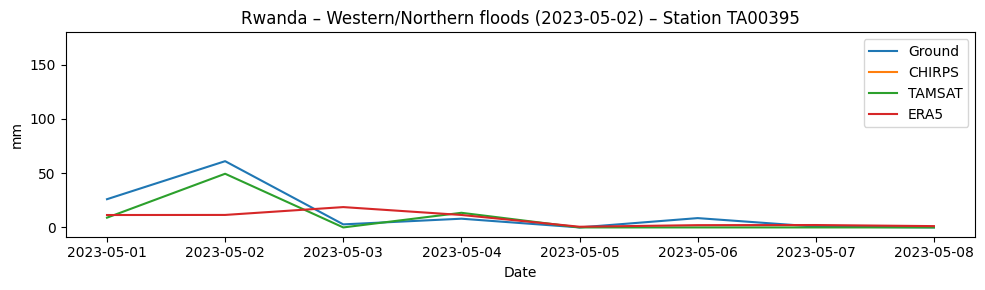

,product,total_mm
0,CHIRPS,182.374710
1,ERA5,59.383456
2,GROUND,107.436000
3,TAMSAT,72.000000


,dataset,rmse,bias,corr_pearson,corr_spearman,hitrate_20mm,hitrate_50mm,hitrate_100mm
0,TAMSAT,8.192800,5.792500,0.946295,0.736485,0.5,0.0,NaN
1,ERA5,19.308724,11.659074,0.371514,0.619048,0.0,0.0,NaN
2,CHIRPS,102.768036,73.871356,1.000000,1.000000,1.0,NaN,NaN


✅ Case study exports saved


In [79]:
# @title Step 8) Run case study {"display-mode":"form"}

# @markdown This section runs case study selected in step 4
# 8) CASE STUDY
import matplotlib.pyplot as plt, os, pandas as pd, numpy as np
if df_gt is None or df_gt.empty or station_w.value is None: print('⚠️ Select station / load ground.')
else:
    sid=station_w.value; st=df_gt[df_gt['station_id']==sid].sort_values('date'); lat,lon=float(st['lat'].iloc[0]),float(st['lon'].iloc[0])
    start_evt,end_evt=[pd.to_datetime(x).tz_localize('UTC') for x in EVENTS[event_w.value]] # Localize to UTC
    s_ground=st.set_index('date')['precip'].loc[start_evt:end_evt]
    src={'CHIRPS':ds_chirps,'TAMSAT':ds_tamsat,'IMERG':ds_imerg,'ERA5':ds_era5}
    series_evt={'GROUND': s_ground}
    for d in dataset_w.value:
        ts=extract_timeseries(src.get(d),lat,lon,k=NEIGHBORHOOD)
        if ts is not None:
            try:
                # Make the extracted timeseries timezone aware (UTC)
                series_evt[d]=ts.tz_localize('UTC').loc[start_evt:end_evt]
            except TypeError:
                # If already timezone aware, assume UTC and slice
                series_evt[d]=ts.tz_convert('UTC').loc[start_evt:end_evt]

    fig=plt.figure(figsize=(10,3))
    if not s_ground.empty: plt.plot(s_ground.index,s_ground.values,label='Ground')
    for d in dataset_w.value:
        if d in series_evt:
            aligned=series_evt[d].reindex(s_ground.index) if not s_ground.empty else series_evt[d]
            plt.plot(aligned.index,aligned.values,label=d)
    plt.title(f"{event_w.value} – Station {sid}"); plt.xlabel('Date'); plt.ylabel('mm'); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,f"event_window_{sid}.png")); plt.show()
    rows=[{'product':k,'total_mm':float(np.nansum(v.values)) if len(v)>0 else np.nan} for k,v in series_evt.items()]
    dft=pd.DataFrame(rows).sort_values('product').reset_index(drop=True); display(dft)
    dft.to_csv(os.path.join(RESULTS_DIR,f"event_totals_{sid}.csv"),index=False)
    rowsm=[]
    for d in dataset_w.value:
        if d in series_evt and len(s_ground)>0:
            from pandas import Series
            met=metrics(s_ground, series_evt[d].reindex(s_ground.index), [20,50,100])
            if met: rowsm.append({'dataset':d,**met})
    if rowsm:
        dfem=pd.DataFrame(rowsm).sort_values(['rmse','bias','corr_pearson'],ascending=[True,True,False]).reset_index(drop=True); display(dfem)
        dfem.to_csv(os.path.join(RESULTS_DIR,f"event_metrics_{sid}.csv"),index=False)
    print('✅ Case study exports saved')

## 9) Summary
- LTN figures, station metrics, case-study plots & tables saved to the **Results** folder.  
- Re-run with different **country / station / event** to compare outcomes.